RNN_Quest_3

Now we give it a real go to get rid of the class imbalances and improve our model even further.

How could we get more data from the underrepresented painters, especially from Carel Fabritius? 

The answer is quite simple: We take more random crops of the images of the underrepresented painters. 

Restructure your data set to get roughly an equal amount of crops for each painter - or at least a minimum amount!

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split


### Date Handling

In [ ]:
classes_to_int = {
 'Albrecht_Duerer':0,
 'Caravaggio':1,
 'Fabritius':2,
 'Giotto_di_Bondone':3,
 'Leonardo_da_Vinci':4,
 'Michelangelo':5,
 'Raphael':6,
 'Rembrandt':7}


# get paths of images 

all_paths = []
y_class = []
for x in os.listdir('Images/'): 
  path = 'Images/' + x
  for y in os.listdir(path):
   all_paths.append('Images/' + x + '/' + y)
   y_class.append(classes_to_int[x])except: 

In [ ]:
X_train_all, X_test_paths, y_train_all, y_test = train_test_split(all_paths, y_class, test_size=0.2, random_state=42, stratify = y_class)

X_train, X_val_paths, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42, stratify = y_train_all)

In [ ]:
# oversample Training Data
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# fit and apply the transform
X_train_over, y_train = oversample.fit_resample(np.asarray(X_train).reshape(-1, 1), y_train)

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1  

In [ ]:
X_train = []
for i in X_train_over.tolist():
    # Load all artist's images stored in path
    image=tf.keras.preprocessing.image.load_img(listToString(i), color_mode='rgb')
    image = np.asarray(image)
    image.astype(np.uint8)
    # append image to list data
    X_train.append(image)

X_val = []
for i in X_val_paths:
    # Load all artist's images stored in path
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb')
    image = np.asarray(image)
    image.astype(np.uint8)
    # append image to list data
    X_val.append(image)
    
X_test = []
for i in X_test_paths:
    # Load all artist's images stored in path
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb')
    image = np.asarray(image)
    image.astype(np.uint8)
    # append image to list data
    X_test.append(image)
    
    

In [ ]:
from collections import Counter
print('Train Label Distribution:')
print(Counter(y_train))

print('Test Label Distribution:')
print(Counter(y_val))

print('Test Label Distribution:')
print(Counter(y_test))

Train Label Distribution:
Counter({0: 210, 5: 210, 6: 210, 7: 210, 4: 210, 3: 210, 2: 210, 1: 210})
Test Label Distribution:
Counter({0: 52, 7: 42, 4: 23, 3: 19, 6: 17, 1: 9, 5: 8, 2: 3})
Test Label Distribution:
Counter({0: 66, 7: 52, 4: 29, 3: 24, 6: 22, 1: 11, 5: 10, 2: 3})


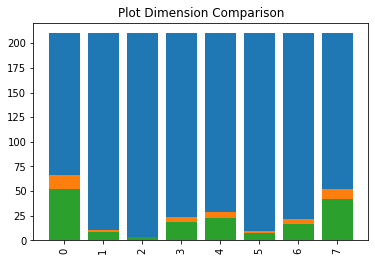

In [ ]:
Train = Counter(y_train)
Val = Counter(y_val)
Test = Counter(y_test)

plt.title('Plot Dimension Comparison')
plt.bar(x = Train.keys() , height= Train.values())
plt.bar(x = Test.keys() , height= Test.values())
plt.bar(x = Val.keys() , height= Val.values())
plt.xticks(rotation = 90)
plt.show()

Now use the models from RNN_Quest_2 and retrain it with the augmented data.

# Cropping

In [ ]:
def get_center_crop(img, crop_size):
 height, width = img.shape[0], img.shape[1]
 dy, dx = crop_size
 x = (width - dx + 1) // 2
 y = (height - dy + 1) // 2
 return img[y:(y+dy), x:(x+dx), :]

def get_random_crop(img, random_crop_size):
# Note: image_data_format is 'channel_last'
 assert img.shape[2] == 3
 height, width = img.shape[0], img.shape[1]
 dy, dx = random_crop_size
 x = np.random.randint(0, width - dx + 1)
 y = np.random.randint(0, height - dy + 1)
 return img[y:(y+dy), x:(x+dx), :]

In [ ]:
# Randomized Cropping for X_train

for i in range(len(X_train)): 
  X_train[i] = get_random_crop(X_train[i], random_crop_size=(224,224))
  
# Center Croping for X_train, X_validaion 

for i in range(len(X_val)): 
  X_val[i] = get_center_crop(X_val[i], crop_size=(224,224))

for i in range(len(X_test)): 
  X_test[i] = get_center_crop(X_test[i], crop_size=(224,224))

# Image Data Generator

In [ ]:
from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
batch_size = 32

############
# Training
############
train_gen = ImageDataGenerator(
    featurewise_center=True, # Zero Center
    samplewise_center=False,
    featurewise_std_normalization=True, # Normalization
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=None,
    shear_range=5.0,
    zoom_range=0.05,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,   ### That is important, because Viswanathan dit it as well
    vertical_flip=False,
    rescale = None,
    preprocessing_function=None,
    data_format=None,
    dtype=None,
)
train_gen.fit(X_train)

train_batches = train_gen.flow(
    x = np.asarray(X_train),
    y=y_train,
    batch_size=batch_size,
    shuffle=True
)

############
# Validation
############

val_gen = ImageDataGenerator(
    featurewise_center=True, # Zero Center
    samplewise_center=False,
    featurewise_std_normalization=True, # Normalization
    samplewise_std_normalization=False,
    rescale = None
)
val_gen.fit(X_train)  # beser auf Trainingsset

val_batches = val_gen.flow(
    x = np.asarray(X_val),
    y=y_val,
    batch_size=batch_size,
    shuffle= True
)    

############
# Test
############
test_gen = ImageDataGenerator(
    featurewise_center=True, # Zero Center
    samplewise_center=False,
    featurewise_std_normalization=True, # Normalization
    samplewise_std_normalization=False,
    rescale = None
)
test_gen.fit(X_train)

test_batches = test_gen.flow(
    x = np.asarray(X_test),
    y=y_test,
    batch_size=batch_size,
    shuffle= False
)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

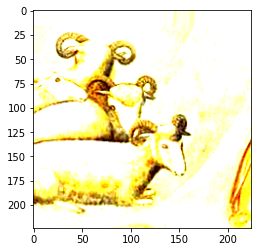

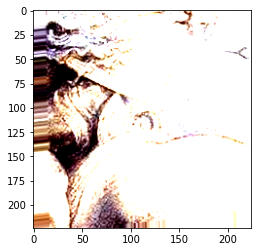

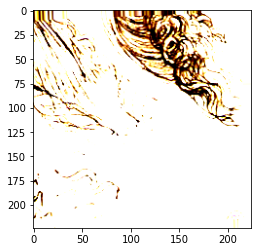

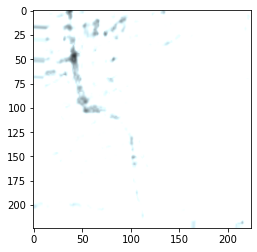

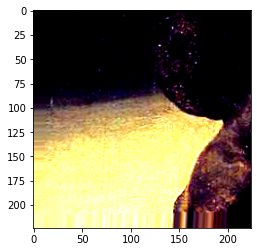

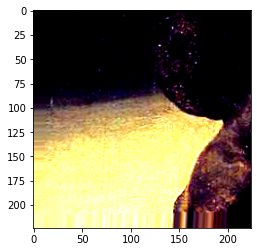

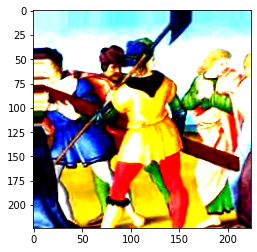

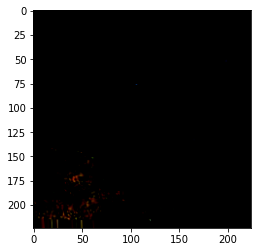

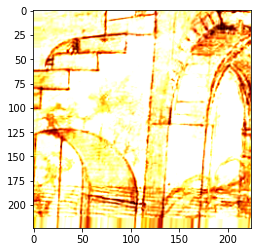

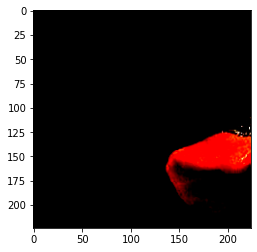

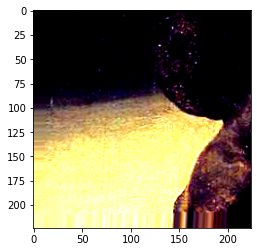

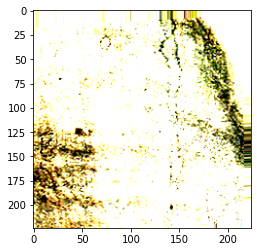

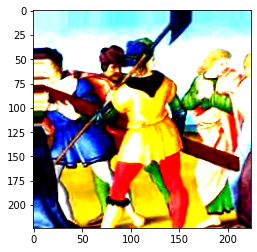

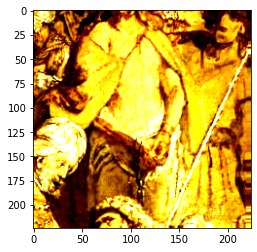

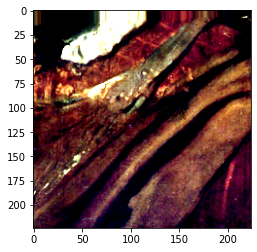

In [ ]:
next_images = train_batches.next()

for i in np.random.randint(0, train_batches.batch_size, 15):
  fig, ax = plt.subplots(1,1, figsize=(4,4))

  # Obtain the i-th image and label of the batch
  img = next_images[0][i]
  label = next_images[1][i]

  # Show the image
  ax.imshow(img)

# Models: 

# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, ReLU, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Load vgg19 model
vgg19 = VGG19(weights='imagenet', 
              include_top=False, 
              input_shape=(224, 224, 3),
              )

#vgg19.summary()

# Freeze the weights
vgg19.trainable = False

In [ ]:
# Add a new classifier and build a new model

# Get the output of vgg19's last layer
last_output = vgg19.layers[-1].output

# Flatten the classifier input which is the output of the last layer
x = Flatten()(last_output)

x = Dense(1024)(x)
#x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
#x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(8, activation='softmax', name='softmax')(x)

my_vgg19 = Model(inputs=vgg19.input, outputs=x)





In [ ]:
# Create checkpoint
mcp_vgg19 = ModelCheckpoint('best_model_vgg19', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [ ]:
# Compile the model
my_vgg19.compile(Adam(lr=0.0001), 
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')

In [ ]:
# lets get better Fabritius Scores
class_weight = {0: 1.,
                1: 1.,
                2: 100.,
                3: 1.,
                4: 1.,
                5: 1.,
                6: 1.,
                7: 1.
               }

In [ ]:
# Train the model
my_vgg19.fit(
    x=train_batches,
    validation_data=val_batches,
    epochs=30,
    workers = 24,
    batch_size = 32,
    steps_per_epoch = 256,
    verbose=1,
    class_weight=class_weight,
    callbacks=mcp_vgg19,
)

# restnet50

In [ ]:
# Load vgg19 model
resnet50 = ResNet50(weights='imagenet', 
                    include_top=False, 
                    input_shape=(224, 224, 3),
                    )

#restnet50.summary()


# Freeze the weights
resnet50.trainable = False

for layer in resnet50.layers[:-5]:
  layer.trainable = True


In [ ]:
# Add a new classifier and build a new model

last_output = resnet50.layers[-1].output
x = AveragePooling2D((7,7))(last_output)
# Flatten the classifier input which is the output of the last layer
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2048, kernel_initializer='he_uniform')(x)

#x = BatchNormalization()(x)
x = ReLU()(x)

x = Dense(16, kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
x = ReLU()(x)
      
x = Dense(9, 
          kernel_initializer=initializers.he_normal(),
          bias_initializer=initializers.ones(), 
          activation='softmax')(x)




my_resnet50 = Model(inputs=resnet50.input, outputs=x)

In [ ]:
# Create checkpoint
mcp_resnet50 = ModelCheckpoint('best_model_resnet50', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [ ]:
# Compile the model
my_resnet50.compile(Adam(lr=0.0001), 
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
# lets get better Fabritius Scores
class_weight = {0: 1.,
                1: 1.,
                2: 100.,
                3: 1.,
                4: 1.,
                5: 1.,
                6: 1.,
                7: 1.
               }

In [ ]:
# Train the model
my_resnet50.fit(x=train_batches,
                validation_data=val_batches,
                epochs=30,
                verbose=1,
                workers = 24,
                class_weight = class_weight,
                steps_per_epoch = 256,
                callbacks=mcp_resnet50,
                )

Epoch 1/30
256/256 [==============================] - ETA: 0s - loss: 11.2887 - accuracy: 0.1799
Epoch 00001: val_accuracy improved from -inf to 0.03468, saving model to best_model_resnet50
INFO:tensorflow:Assets written to: best_model_resnet50\assets
256/256 [==============================] - 118s 461ms/step - loss: 11.2887 - accuracy: 0.1799 - val_loss: 27.9525 - val_accuracy: 0.0347
Epoch 2/30
256/256 [==============================] - ETA: 0s - loss: 8.3502 - accuracy: 0.2342
Epoch 00002: val_accuracy did not improve from 0.03468
256/256 [==============================] - 42s 164ms/step - loss: 8.3502 - accuracy: 0.2342 - val_loss: 5.7985 - val_accuracy: 0.0231
Epoch 3/30
256/256 [==============================] - ETA: 0s - loss: 7.0947 - accuracy: 0.2942
Epoch 00003: val_accuracy improved from 0.03468 to 0.21965, saving model to best_model_resnet50
INFO:tensorflow:Assets written to: best_model_resnet50\assets
256/256 [==============================] - 115s 449ms/step - loss: 7.094

Epoch 28/30
256/256 [==============================] - ETA: 0s - loss: 1.7448 - accuracy: 0.6829
Epoch 00028: val_accuracy did not improve from 0.79191
256/256 [==============================] - 42s 164ms/step - loss: 1.7448 - accuracy: 0.6829 - val_loss: 1.6218 - val_accuracy: 0.6590
Epoch 29/30
256/256 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.7205
Epoch 00029: val_accuracy did not improve from 0.79191
256/256 [==============================] - 43s 166ms/step - loss: 1.1269 - accuracy: 0.7205 - val_loss: 1.6454 - val_accuracy: 0.6994
Epoch 30/30
256/256 [==============================] - ETA: 0s - loss: 1.5633 - accuracy: 0.6842
Epoch 00030: val_accuracy did not improve from 0.79191
256/256 [==============================] - 42s 165ms/step - loss: 1.5633 - accuracy: 0.6842 - val_loss: 1.0697 - val_accuracy: 0.7803


# Model Evaluation

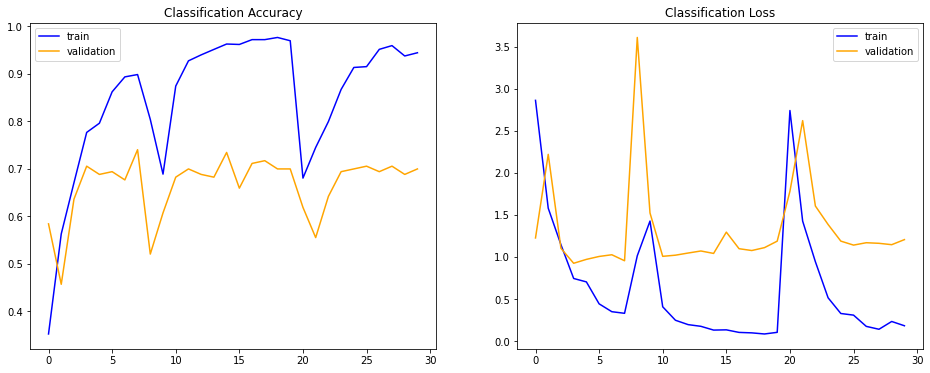

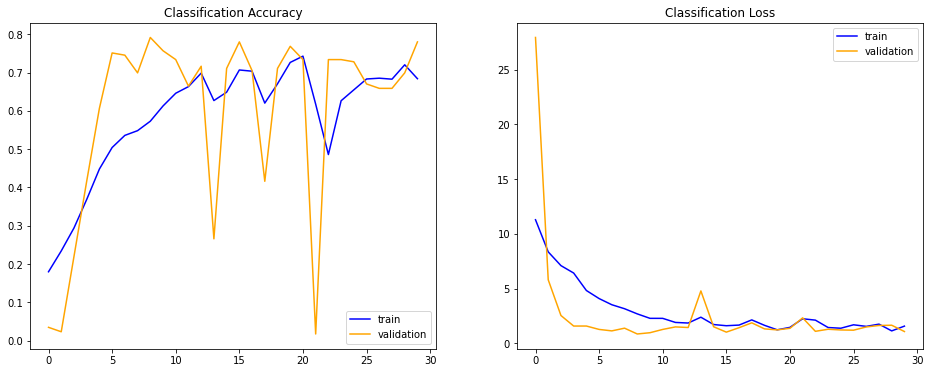

In [ ]:
from tensorflow.python.keras.callbacks import History

def plot_training_history(history: History):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Classification Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.legend()

  plt.show()

plot_training_history(my_vgg19.history)
plot_training_history(my_resnet50.history)

In [ ]:
# load best model
best_model_vgg19 = load_model('best_model_vgg19')
# evaluate best model
from sklearn.metrics import accuracy_score
accuracy_score(y_true = y_test , y_pred=  np.argmax(best_model_vgg19.predict(x=test_batches, verbose=1), axis = 1) )


7/7 [==============================] - 1s 129ms/step


0.7557603686635944

In [ ]:
# load best model
best_model_resnet50 = load_model('best_model_resnet50')
# evaluate best model
accuracy_score(y_true = y_test , y_pred=  np.argmax(best_model_resnet50.predict(x=test_batches, verbose=1), axis = 1) )



7/7 [==============================] - 1s 80ms/step


0.8018433179723502

In [ ]:
from sklearn.metrics import confusion_matrix
# after Discussion with Peter: 

def get_accuracy_by_class(y_true, y_pred, classes):
  ### Stolen from https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
  ### Accurac = TP + TN / (TP + TN + FP + FN)
  # Get the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # We will store the results in a dictionary for easy access later
  per_class_accuracies = {}

  # Calculate the accuracy for each one of our classes
  for idx, cls in enumerate(classes):
    # True negatives are all the samples that are not our current class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
  
  return per_class_accuracies

In [ ]:
# Get Predictions for each Modell
y_pred_vgg19 = np.argmax(best_model_vgg19.predict(x=test_batches, verbose=1), axis = 1)
y_pred_resnet50 = np.argmax(best_model_resnet50.predict(x=test_batches, verbose=1), axis = 1)

7/7 [==============================] - 0s 44ms/step


In [ ]:
vgg_19_accuracies_per_class = get_accuracy_by_class(y_test, y_pred_vgg19, classes_to_int.values())

re50_accuracies_per_class = get_accuracy_by_class(y_test, y_pred_resnet50, classes_to_int.values())

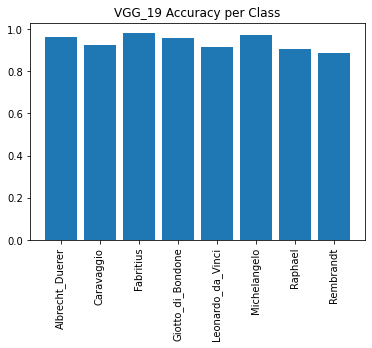

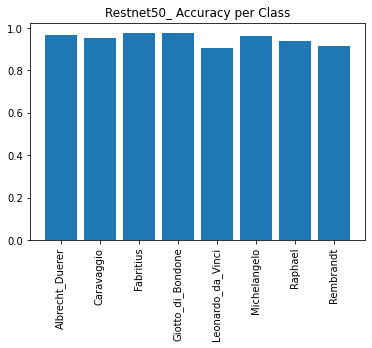

In [ ]:
import matplotlib.pyplot as plt
plt.bar(x = classes_to_int.keys(), height = vgg_19_accuracies_per_class.values())
plt.title('VGG_19 Accuracy per Class')
plt.xticks(rotation=90)
plt.show()


plt.bar(x = classes_to_int.keys(), height = re50_accuracies_per_class.values())
plt.title('Restnet50_ Accuracy per Class')
plt.xticks(rotation=90)
plt.show()

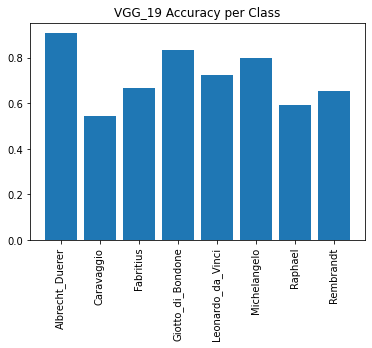

In [ ]:
from sklearn.metrics import confusion_matrix

matrix_vgg19 = confusion_matrix(y_test, y_pred_vgg19)
vgg_19_accuracies_per_class = matrix_vgg19.diagonal()/matrix_vgg19.sum(axis=1)


import matplotlib.pyplot as plt
plt.bar(x = classes_to_int.keys(), height = vgg_19_accuracies_per_class)
plt.title('VGG_19 Accuracy per Class')
plt.xticks(rotation=90)
plt.show()

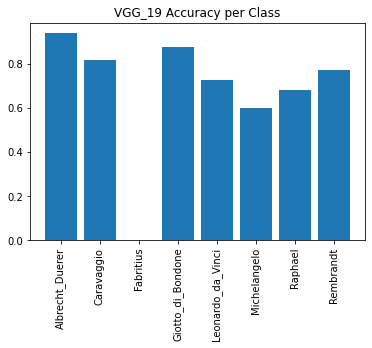

In [ ]:
from sklearn.metrics import confusion_matrix

matrix_restnet50 = confusion_matrix(y_test, y_pred_resnet50)
restnet50_accuracies_per_class = matrix_restnet50.diagonal()/matrix_restnet50.sum(axis=1)


import matplotlib.pyplot as plt
plt.bar(x = classes_to_int.keys(), height = restnet50_accuracies_per_class)
plt.title('Restnet50 Accuracy per Class')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('VGG19 Model')
print(classification_report(y_test, y_pred_vgg19, target_names= list(classes_to_int.keys()) ))
print('######################################################################')
print('Restnet50 Model')
print(classification_report(y_test, y_pred_resnet50, target_names= list(classes_to_int.keys()) ))

VGG19 Model
                   precision    recall  f1-score   support

  Albrecht_Duerer       0.97      0.91      0.94        66
       Caravaggio       0.35      0.55      0.43        11
        Fabritius       0.40      0.67      0.50         3
Giotto_di_Bondone       0.80      0.83      0.82        24
Leonardo_da_Vinci       0.68      0.72      0.70        29
     Michelangelo       0.67      0.80      0.73        10
          Raphael       0.54      0.59      0.57        22
        Rembrandt       0.83      0.65      0.73        52

         accuracy                           0.76       217
        macro avg       0.65      0.72      0.68       217
     weighted avg       0.78      0.76      0.76       217

######################################################################
Restnet50 Model
                   precision    recall  f1-score   support

  Albrecht_Duerer       0.95      0.94      0.95        66
       Caravaggio       0.53      0.82      0.64        11
        Fabr